In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         compute_corrected_ew_col,
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
pd.set_option('display.max_rows', None)

# analyze_tau version that only applies tau correction to core range (but, includes all points in optimization)
# (cleaned-up version of 3-region analyze_tau script, also using slope tau optimization)

In [2]:
# Define functions to process data

def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed EQX OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Unique observation names:', len(obsdata))
    print()
    
    return obsdata

def remove_outliers(obsdata, outlier_obs):
    #remove 3 outliers from ~phase 50-60 before fitting for tau
    #(located by hand, removing from all 3 by observation name)
    
    for obsid in outlier_obs:
        #drop row containing outlier ob
        obsdata = obsdata[obsdata.index != obsid]
            
    print('Removed outlier OBSIDs:', outlier_obs)
    print('Unique observation names:', len(obsdata))
    print()
    return obsdata


In [3]:
# Define variables

# directory of dumped EW csv files
# dump_ew_dir = '/Users/mlessard/REU_2022/data/dump_ew_csv/'
dump_ew_dir = '/seti/src/f-ring/data_files/'

#use all 3 regions, 4 boundaries between the regions
radii = ['139470', '140120', '140320', '140965']

size = '0' #slice/step size of the csv file, currently only have 0

#degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

#list outlier obsids
outliers = ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']

In [4]:
# Read in the CSV files (full-width, then the 3 different regions)

#get the full-width image data
full_img_filepath = f'{dump_ew_dir}ew_stats_{radii[0]}_{radii[1]}_{radii[2]}_{radii[3]}_{size}.csv'
full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date'], index_col='Observation'); ms=20; alpha=0.7

#calculate mu, mu0 
full_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(full_orig_obsdata['Mean Emission'])))
full_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(full_orig_obsdata['Incidence'])))

In [5]:
#print initial statistics
print('** SUMMARY STATISTICS **')
print('Unique observation names:', len(full_orig_obsdata.groupby('Observation')))
print('Total slices:', len(full_orig_obsdata))
print('Starting date:', full_orig_obsdata['Date'].min())
print('Ending date:', full_orig_obsdata['Date'].max())
print('Time span:', full_orig_obsdata['Date'].max()-full_orig_obsdata['Date'].min())
print()

print(full_img_filepath)
print()


** SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

/seti/src/f-ring/data_files/ew_stats_139470_140120_140320_140965_0.csv



In [6]:
#remove EQX observations
removed_eqx_obsdata = remove_eqx(full_orig_obsdata, eqx_cutoff)

#remove outliers
obsdata = remove_outliers(removed_eqx_obsdata, outliers)

Removed EQX OBSIDs: {'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME'}
Unique observation names: 145

Removed outlier OBSIDs: ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']
Unique observation names: 142



<h1> Optimize Tau for Low-Phase Observations </h1>

In [7]:
# Find "small" (<6) e or i
low_phase_mask = obsdata['Mean Phase'] <= 60
low_phase_obsdata = obsdata[low_phase_mask]
lp_low_e_mask = np.abs(low_phase_obsdata['Mean Emission']-90) < 6
lp_low_i_mask = np.abs(low_phase_obsdata['Incidence']-90) < 6
lp_low_ei_mask = lp_low_e_mask | lp_low_i_mask

low_e_mask = np.abs(obsdata['Mean Emission']-90) < 6
low_i_mask = np.abs(obsdata['Incidence']-90) < 6
low_ei_mask = low_e_mask | low_i_mask

In [8]:
# Find the optimal tau to minimize scatter
# only apply the tau correction to the core/Region 2, but use all 3's values to optimize w/ slope/scatter/etc.
# also only use the low-phase data to calculate
best_tau = None
best_slope = 1e38
for tau in np.arange(0.000, 0.101, 0.001):
    
    #get the tau-adjusted EW values for the core/Region 2
    corrected_ew = compute_corrected_ew_col(low_phase_obsdata, col_tau=('Normal EWI', None,
                                                                        'Normal EWC', tau,
                                                                        'Normal EWO', None)) 
    
    coeff = np.polyfit(low_phase_obsdata['Mu0'], corrected_ew, 1)
    if abs(coeff[0]) < best_slope:
        best_slope = abs(coeff[0])
        best_tau = tau
    #print(f'Tau {tau:.3f} - Slope: {coeff[0]:8.5f}')

print()
print(f'** Best Tau: {best_tau:.3f}')


** Best Tau: 0.053


In [9]:
#add column with corrected EW (using best-fit tau)

#total corrected EW:
total_c_ew = compute_corrected_ew_col(obsdata, col_tau=('Normal EWI', None,
                                                        'Normal EWC', best_tau,
                                                        'Normal EWO', None)) 

#add values as additional columns to dataframes
obsdata['Total C EW'] = total_c_ew
low_phase_obsdata = obsdata[low_phase_mask]

In [10]:
#calculate means of uncorrected (UC) vs. corrected (C) low-phase data, display

print()
print('Uncorrected Low Phase:')
uc_mean_low = np.mean(low_phase_obsdata['Normal EW'][lp_low_ei_mask])
uc_mean_notlow = np.mean(low_phase_obsdata['Normal EW'][~lp_low_ei_mask])
print(f'Mean Normal EW Low E/I:  {uc_mean_low:.5f}')
print(f'Mean Normal EW High E/I: {uc_mean_notlow:.5f}')
print(f'High/Low: {uc_mean_notlow/uc_mean_low:.5f}')
print()

lp_corrected_ew = low_phase_obsdata['Total C EW']
mean_low = np.mean(lp_corrected_ew[lp_low_ei_mask])
mean_notlow = np.mean(lp_corrected_ew[~lp_low_ei_mask])
print(f'Corrected (tau={best_tau:.3f}) Low Phase:')
print(f'Mean Normal EW Low E/I:  {mean_low:.5f}')
print(f'Mean Normal EW High E/I: {mean_notlow:.5f}')
print(f'High/Low: {mean_notlow/mean_low:.5f}')

print()
print('Overall change due to Tau:')
print(f'Mean Normal EW Low E/I: {mean_low/uc_mean_low:.5f}')
print(f'Mean Normal EW Other:   {mean_notlow/uc_mean_notlow:.5f}')


Uncorrected Low Phase:
Mean Normal EW Low E/I:  0.51442
Mean Normal EW High E/I: 0.57925
High/Low: 1.12604

Corrected (tau=0.053) Low Phase:
Mean Normal EW Low E/I:  0.65429
Mean Normal EW High E/I: 0.65053
High/Low: 0.99424

Overall change due to Tau:
Mean Normal EW Low E/I: 1.27191
Mean Normal EW Other:   1.12304


In [11]:
# Find H-G phase curve for full dataset
corrected_ew = obsdata['Total C EW']

uc_hg_params, uc_hg_used_data, uc_hg_std = fit_hg_phase_function(2, None, obsdata, col_tau=('Normal EW', None),
                                                                 verbose=False)
print()
print('Uncorrected H-G params:')
print_hg_params(uc_hg_params, indent=2)
print(f'  Standard deviation: {uc_hg_std:.5f}')


#(do NOT submit a best_tau value to function, already applied tau correction on center alone)
hg_params, hg_used_data, hg_std = fit_hg_phase_function(2, None, obsdata, col_tau=('Total C EW', None),
                                                        verbose=False)
print()
print(f'Corrected (tau={best_tau:.3f}) params:')
print_hg_params(hg_params, indent=2)
print(f'  Standard deviation: {hg_std:.5f}')


Uncorrected H-G params:
  g1 =  0.649 / scale1 =  1.686 / weight1 = 0.647
  g2 =  0.024 / scale2 =  0.922 / weight2 = 0.353
  Standard deviation: 0.05380

Corrected (tau=0.053) params:
  g1 =  0.635 / scale1 =  1.919 / weight1 = 0.657
  g2 = -0.007 / scale2 =  1.000 / weight2 = 0.343
  Standard deviation: 0.05335


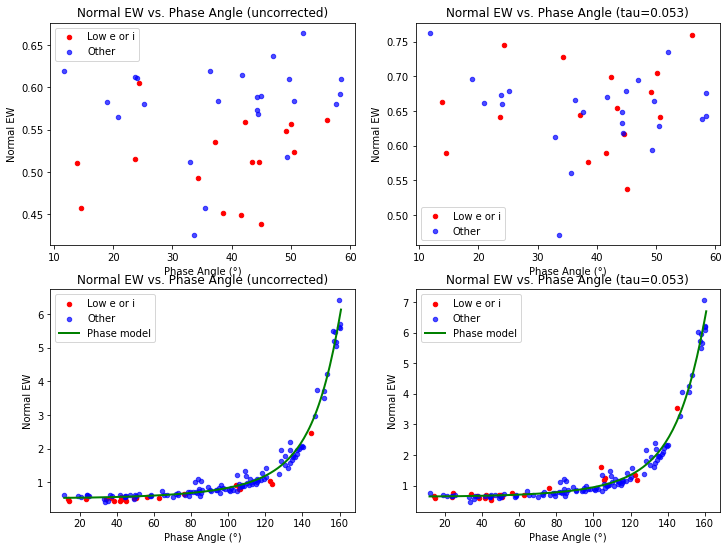

In [12]:
# Plot results
plt.figure(figsize=(12,9)) 
plt.subplot(2, 2, 1) #figure 1: low-phase, uncorrected
plt.scatter(low_phase_obsdata['Mean Phase'][lp_low_ei_mask], 
            low_phase_obsdata['Normal EW'][lp_low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(low_phase_obsdata['Mean Phase'][~lp_low_ei_mask], 
            low_phase_obsdata['Normal EW'][~lp_low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

plt.subplot(2, 2, 2) #figure 2: low-phase, corrected
plt.scatter(low_phase_obsdata['Mean Phase'][lp_low_ei_mask], 
            lp_corrected_ew[lp_low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(low_phase_obsdata['Mean Phase'][~lp_low_ei_mask], 
            lp_corrected_ew[~lp_low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle (tau={best_tau:.3f})')

plt.subplot(2, 2, 3) #figure 3: all data, uncorrected
plt.scatter(obsdata['Mean Phase'][low_ei_mask], 
            obsdata['Normal EW'][low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(obsdata['Mean Phase'][~low_ei_mask], 
            obsdata['Normal EW'][~low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
uc_hg_phase_model = hg_func(uc_hg_params, np.radians(xrange))
plt.plot(xrange, uc_hg_phase_model, '-', color='green', lw=2, label='Phase model')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

plt.subplot(2, 2, 4) #figure 4: all data, corrected
plt.scatter(obsdata['Mean Phase'][low_ei_mask], 
            corrected_ew[low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(obsdata['Mean Phase'][~low_ei_mask], 
            corrected_ew[~low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
hg_phase_model = hg_func(hg_params, np.radians(xrange))
plt.plot(xrange, hg_phase_model, '-', color='green', lw=2, label='Phase model')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle (tau={best_tau:.3f})')
plt.show()

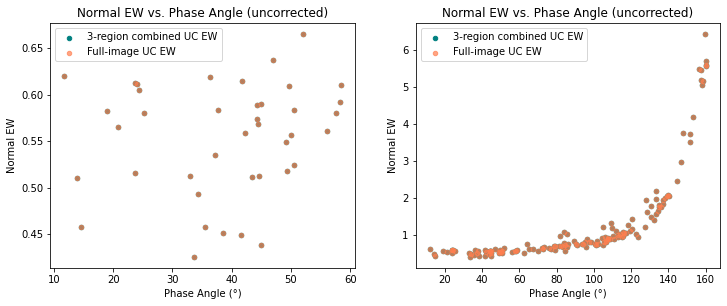

In [13]:
# plot the original Normal EW values against the combined (UC) EW values from the 3 regions
plt.figure(figsize=(12,4.5)) 
plt.subplot(1,2,1)
plt.scatter(low_phase_obsdata['Mean Phase'], 
            low_phase_obsdata['Normal EW'], 
            s=ms, c='teal', label='3-region combined UC EW')
plt.scatter(low_phase_obsdata['Mean Phase'], 
            low_phase_obsdata['Normal EW'], 
            s=ms, alpha=alpha, c='coral', label='Full-image UC EW')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')


plt.subplot(1,2,2)
plt.scatter(obsdata['Mean Phase'], 
            obsdata['Normal EW'], 
            s=ms, c='teal', label='3-region combined UC EW')
plt.scatter(obsdata['Mean Phase'], 
            obsdata['Normal EW'], 
            s=ms, alpha=alpha, c='coral', label='Full-image UC EW')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
_=plt.title('Normal EW vs. Phase Angle (uncorrected)')

